In [17]:
import classy
import camb
from astropy.cosmology import Planck15
import matplotlib.pyplot as plt
import numpy as np
import hmf
from scipy.interpolate import InterpolatedUnivariateSpline as spline

In [18]:
h = Planck15.h
cosmo = Planck15

# Setting up camb params

In [19]:
camb_params = camb.CAMBparams()
camb_params.set_cosmology(
    H0=Planck15.H0.value, ombh2=Planck15.Ob0 * h**2, omch2=(Planck15.Om0 - Planck15.Ob0) * h**2,
    omk = Planck15.Ok0, nnu = Planck15.Neff, TCMB=Planck15.Tcmb0.value
);
camb_params.WantTransfer = True

camb_transfers = camb.get_transfer_functions(camb_params)
camb_trans = camb_transfers.get_matter_transfer_data().transfer_data[[0,6],:,0]

# HMF transfer model
camb_tmodel = hmf.transfer_models.CAMB(Planck15)

### Comparing with HMF CAMB transfer model

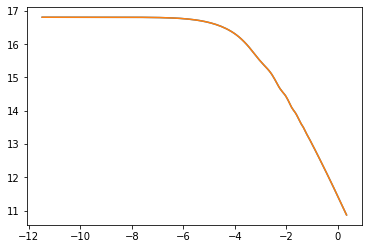

In [20]:
lnk,lnt = np.log(camb_trans)

plt.plot(np.log(k), np.log(T))
plt.plot(np.log(k), camb_tmodel.lnt(lnk))

# Classy transfer function comparison

In [21]:
import classy

In [22]:
class_params = {
    'omega_b': cosmo.Ob0 * h**2, 'omega_cdm': (cosmo.Om0 - cosmo.Ob0) * h**2,
    'h': cosmo.h, 'A_s': 2.097e-9, 'n_s': 0.9652, 'tau_reio': 0.0540, 'P_k_max_1/Mpc': 100,
    'output': 'dTk,mPk'
}
cl = classy.Class()
cl.set(class_params)
cl.compute()

In [23]:
cl_trans = cl.get_transfer(output_format='camb')
cl_trans = np.array([cl_trans['k (h/Mpc)'], cl_trans['-T_tot/k2']])

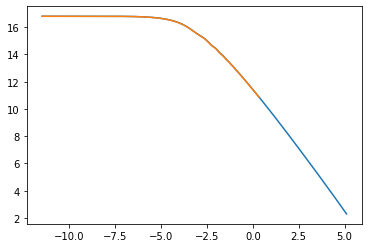

In [24]:
plt.plot(*np.log(cl_trans))
plt.plot(*np.log(camb_trans))

### Some CLASS/CAMB comparisons

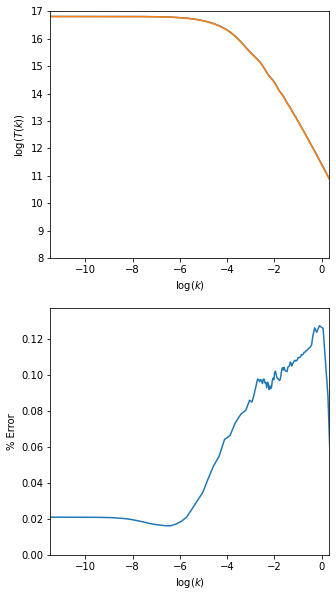

In [25]:
lnk, lnTcl = np.log(cl_trans)
lnTcmb = camb_tmodel.lnt(lnk)

kmin, kmax = np.log(camb_trans[0][0]), np.log(camb_trans[0][-1])

fig, axes = plt.subplots(2,1, figsize=(5,10))
### Makes transfer plot 
a = axes[0]
a.plot(lnk, lnTcl)
a.plot(lnk, lnTcmb)
a.set_xlim(kmin, kmax)
a.set_ylim(8,17)
a.set_xlabel(r'$\log(k)$')
a.set_ylabel(r'$\log(T(k))$')

### Makes error plot
a = axes[1]
err = (lnTcl - lnTcmb) / ((lnTcl + lnTcmb)/2) * 100
a.plot(lnk, err)
a.set_xlim(kmin, kmax)
a.set_ylim(0, max(err)+ 0.01)
a.set_xlabel(r'$\log(k)$')
a.set_ylabel(r'% Error')

plt.show()

# Creating Custom transfer component for CLASS

In [26]:
from hmf.transfer_models import CAMB

In [27]:
class CLASS_Transfer(hmf.transfer_models.FromFile):
    """
    Transfer function computed by CLASS. 
    
    Parameters
    ----------
    
    cosmo : :class:`astropy.cosmology.FLRW` instance
        The cosmology used in the calculation

    \*\*model_parameters : unpack-dict
        Parameters specific to this model.

        **class_params:** 
            Dict of params to set for CLASS object
        **class_object:** 
            Custom class object. If not set, a new Class object will be 
            created.
    """
    _defaults = {"class_params": None, "class_obj": None}
    
    def __init__(self, *args, **kwargs):
        super(CLASS_Transfer, self).__init__(*args, **kwargs)
        self.spline_fn = None

        if self.params['class_obj'] is not None:
            self.class_obj = self.params['class_obj']
        else:
            self.class_obj = classy.Class()
            class_params = self.params['class_params']
            if class_params is None:
                class_params = {}
                
            h = self.cosmo.h
            defaults = {
                'omega_b': self.cosmo.Ob0 * h**2, 
                'omega_cdm': (self.cosmo.Om0 - self.cosmo.Ob0) * h**2,
                'h': h,
            }
            for k,v in defaults.items():
                class_params.setdefault(k,v)
            class_params['output'] = 'dTk'            

            self.class_obj.set(class_params)
        
    def lnt(self, lnk):
        if self.spline_fn is None:
            trans = self.class_obj.get_transfer(output_format='camb')
            if not trans:
                self.class_obj.compute()
                trans = self.class_obj.get_transfer(output_format='camb')

            _lnk, _lnt = np.log(trans['k (h/Mpc)']), np.log(trans['-T_tot/k2'])
            if lnk[0] < _lnk[0]:
                _lnk, _lnt = self._check_low_k(_lnk, _lnt, lnk[0])
            self.spline_fn = spline(_lnk, _lnt, k=1)
            
        return self.spline_fn(lnk)

In [28]:
mf = hmf.MassFunction()
lnk = np.log(mf.k)
class_t = CLASS_Transfer(Planck15)
camb_t = CAMB(Planck15)

clt = class_t.lnt(lnk)
cambt = camb_t.lnt(lnk)

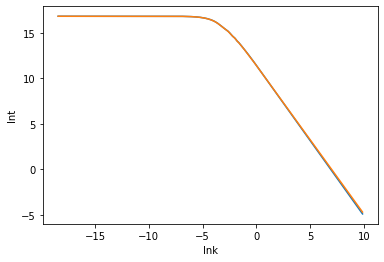

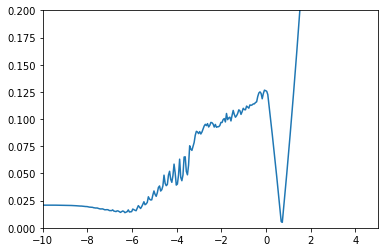

In [29]:
plt.plot(lnk, clt)
plt.plot(lnk, cambt)
plt.xlabel("lnk")
plt.ylabel("lnt")
plt.show()

perc_diff = 100 * np.abs(clt - cambt)/ ((clt + cambt)/2)
plt.plot(lnk, perc_diff)
plt.xlim(-10, 5)
plt.ylim(0, 0.2)
plt.show()

# HMF pk / CLASS pk comparison

In [30]:
cosmo = Planck15
h = cosmo.h
class_params = {
    'omega_b': cosmo.Ob0 * h**2, 'omega_cdm': (cosmo.Om0 - cosmo.Ob0) * h**2,
    'h': cosmo.h, 'A_s': 2.097e-9, 'n_s': 0.9652, 'tau_reio': 0.0540, 'P_k_max_1/Mpc': 100,
    'output': 'dTk,mPk'
}
cl = classy.Class()
cl.set(class_params)
cl.compute()

In [31]:
mf = hmf.hmf.MassFunction(
    transfer_model=CLASS_Transfer,
    transfer_params = {'class_obj': cl},
    cosmo_model=cosmo,
    z=0,
)

In [32]:
mask = mf.k<100
class_pk = np.array([cl.pk(k*h, 0) for k in mf.k[mask]]) * h**3

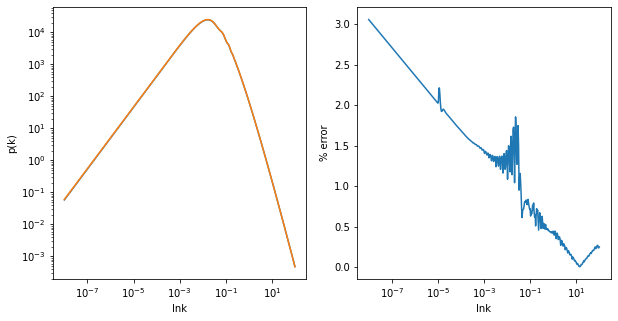

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

a = ax[0]
a.plot(mf.k[mask], mf.power[mask])
a.plot(mf.k[mask], class_pk)
a.set_xscale('log')
a.set_yscale('log')
a.set_xlabel('lnk')
a.set_ylabel('p(k)')

diff = mf.power[mask] - class_pk
perc_err = 100*np.abs(diff) / ((mf.power[mask] + class_pk)/2)
a = ax[1]
a.plot(mf.k[mask], perc_err)
a.set_xscale('log')
a.set_xlabel('lnk')
a.set_ylabel('% error')

plt.show()